## LAB SQL QUERIES 9

##### We will use the Sakila database.
##### We will be trying to predict if a customer will be renting a film this month based on their previous activity and other details. We will first construct a table with:

##### - Customer ID
##### - City
##### - Most rented film category
##### - Total films rented
##### - Total money spent
##### - How many films rented last month

##### And try to predict if he will be renting this month.
##### Use date range (`15/05/2005` - `30/05/2005`) for last month and (`15/06/2005` - `30/06/2005`) for this month.

### 1. Importing libraries

In [1]:
import sqlalchemy
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


### 2. Establishing the connection with MySQL and getting a Panda's dataframe (df) called "data" out of a MySQL query

In [20]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

### Importing SQL Queries:

####  Customer ID / City / Total films rented / Total money spent

In [60]:
query1 = 'SELECT a.customer_id, c.city AS "City", count(d.rental_id) AS "Total films rented", sum(amount) AS "Total money spent" FROM sakila.customer AS a \
JOIN sakila.address AS b ON a.address_id = b.address_id \
JOIN sakila.city AS c ON b.city_id = c.city_id \
JOIN sakila.payment AS d ON a.customer_id = d.customer_id \
JOIN sakila.rental AS e ON d.rental_id = e.rental_id \
group by a.customer_id \
ORDER BY a.customer_id DESC;'

data_query1 = pd.read_sql_query(query1, engine)
data_query1.head()

,customer_id,City,Total films rented,Total money spent
0,599,Tieli,19,83.81
1,598,Lausanne,22,83.78
2,597,Sullana,25,99.75
3,596,Patras,28,96.72
4,595,Jinzhou,30,117.70


In [61]:
data_query1.shape

(599, 4)

##### Most rented film category

In [62]:
query2 = 'SELECT customer as "customer_id", Category_name FROM \
(SELECT rental.customer_id as customer, count(rental.rental_id) as total_rentals, film_category.category_id, category.name as Category_name, \
row_number() over (partition by rental.customer_id order by count(rental.rental_id) desc) as ranking_max_rented_category \
FROM rental \
INNER JOIN inventory ON rental.inventory_id = inventory.inventory_id \
INNER JOIN film_category ON inventory.film_id = film_category.film_id \
INNER JOIN category ON film_category.category_id = category.category_id \
GROUP BY rental.customer_id, film_category.category_id, category.name) AS table_popular_category \
WHERE ranking_max_rented_category = 1 \
ORDER BY customer;' 

data_query2 = pd.read_sql_query(query2, engine)
data_query2.head()

,customer_id,Category_name
0,1,Classics
1,2,Sports
2,3,Action
3,4,Horror
4,5,Classics


In [63]:
data_query2.shape

(599, 2)

##### Rented during second half May?

In [64]:
query3 = 'SELECT customer_id, \
case \
    when count(rental_id) > 0 then "Y" \
    else "N" \
end as "Rented May" \
FROM sakila.rental \
where rental_date >= 20050515 and rental_date <= 20050530 \
group by customer_id \
ORDER BY customer_id;' 

data_query3 = pd.read_sql_query(query3, engine)
data_query3.head()

,customer_id,Rented May
0,1,Y
1,2,Y
2,3,Y
3,5,Y
4,6,Y


##### Rented during first half June?

In [65]:
query4 = 'SELECT customer_id, \
case \
    when count(rental_id) > 0 then "Y" \
    else "N" \
end as "Rented June" \
FROM sakila.rental \
where rental_date >= 20050601 and rental_date <= 20050615 \
group by customer_id \
ORDER BY customer_id;'
data_query4 = pd.read_sql_query(query4, engine)
data_query4.head()

,customer_id,Rented June
0,46,Y
1,49,Y
2,139,Y
3,191,Y
4,239,Y


## 3. Re-arranging dataframe

#### Join 4 tables

In [66]:
# data_merge = data_query1.merge(data_query2, how='outer').fillna(0)
# data_merge

In [67]:
# importing functools for reduce() 
import functools 

data_frames = [data_query1, data_query2, data_query3, data_query4]
data_merge = functools.reduce(lambda  left,right: pd.merge(left,right,on=['customer_id'], how='outer'), data_frames).fillna('N')
data_merge

,customer_id,City,Total films rented,Total money spent,Category_name,Rented May,Rented June
0,599,Tieli,19,83.81,Sci-Fi,N,N
1,598,Lausanne,22,83.78,Drama,N,N
2,597,Sullana,25,99.75,Foreign,Y,N
3,596,Patras,28,96.72,Sports,Y,N
4,595,Jinzhou,30,117.70,Documentary,Y,Y
...,...,...,...,...,...,...,...
594,5,Nantou,38,144.62,Classics,Y,N
595,4,Myingyan,22,81.78,Horror,N,N
596,3,Athenai,26,135.74,Action,Y,N
597,2,San Bernardino,27,128.73,Sports,Y,N


#### Change header names

In [68]:
data_named = data_merge.rename(columns = {'customer_id':'Customer ID', 'Category_name':'Most rented category'})
data_named

,Customer ID,City,Total films rented,Total money spent,Most rented category,Rented May,Rented June
0,599,Tieli,19,83.81,Sci-Fi,N,N
1,598,Lausanne,22,83.78,Drama,N,N
2,597,Sullana,25,99.75,Foreign,Y,N
3,596,Patras,28,96.72,Sports,Y,N
4,595,Jinzhou,30,117.70,Documentary,Y,Y
...,...,...,...,...,...,...,...
594,5,Nantou,38,144.62,Classics,Y,N
595,4,Myingyan,22,81.78,Horror,N,N
596,3,Athenai,26,135.74,Action,Y,N
597,2,San Bernardino,27,128.73,Sports,Y,N


#### Re-arrange column position

In [69]:
data_named.columns

Index(['Customer ID', 'City', 'Total films rented', 'Total money spent',
       'Most rented category', 'Rented May', 'Rented June'],
      dtype='object')

In [70]:
data = data_named[['Customer ID', 'City', 'Most rented category', 'Total films rented', 'Total money spent', 'Rented May', 'Rented June']]
data

,Customer ID,City,Most rented category,Total films rented,Total money spent,Rented May,Rented June
0,599,Tieli,Sci-Fi,19,83.81,N,N
1,598,Lausanne,Drama,22,83.78,N,N
2,597,Sullana,Foreign,25,99.75,Y,N
3,596,Patras,Sports,28,96.72,Y,N
4,595,Jinzhou,Documentary,30,117.70,Y,Y
...,...,...,...,...,...,...,...
594,5,Nantou,Classics,38,144.62,Y,N
595,4,Myingyan,Horror,22,81.78,N,N
596,3,Athenai,Action,26,135.74,Y,N
597,2,San Bernardino,Sports,27,128.73,Y,N


## 4. Data exploration

In [71]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

#### Shape and column types

In [72]:
print("The dataframe has {} rows and {} columns".format(data.shape[0],data.shape[1]))
print()
print("The data types of each column of the dataframe are:")
print(data.dtypes)
print()

The dataframe has 599 rows and 7 columns

The data types of each column of the dataframe are:
Customer ID               int64
City                     object
Most rented category     object
Total films rented        int64
Total money spent       float64
Rented May               object
Rented June              object
dtype: object



In [126]:
# Change Customer ID to object

data['Customer ID'] = data['Customer ID'].astype('str')
data['Customer ID'] = data['Customer ID'].astype('object')

In [127]:
data.dtypes

Customer ID              object
City                     object
Most rented category     object
Total films rented        int64
Total money spent       float64
Rented May               object
Rented June              object
dtype: object

#### Statistical summary of numerical columns

In [122]:
data.describe()

,Total films rented,Total money spent
count,599.000000,599.000000
mean,26.784641,112.531820
std,5.110357,25.365837
min,12.000000,50.850000
25%,23.000000,94.785000
50%,26.000000,110.730000
75%,30.000000,128.705000
max,46.000000,221.550000


#### Looking for NA's

In [123]:
print("The number of NA's in the dataframe is: ")
print(data.isna().sum())
print()

The number of NA's in the dataframe is: 
Customer ID             0
City                    0
Most rented category    0
Total films rented      0
Total money spent       0
Rented May              0
Rented June             0
dtype: int64



## Categorical columns

In [125]:
cols_cat = data.select_dtypes(include=['object']).columns
cols_cat = data.select_dtypes(include=['object']).columns
print("The categorical columns are: ",cols_cat)
print("========================================")
print()
for col in cols_cat:
    print("Frequency analysis of column: ",col)
    my_data = data[col].value_counts().reset_index()
    ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
    plt.figure()
    print()

The categorical columns are:  Index(['Customer ID', 'City', 'Most rented category', 'Rented May',
       'Rented June'],
      dtype='object')

Frequency analysis of column:  Customer ID


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
data.columns

#### Dummyfying categorical columns

In [112]:
cat = data.select_dtypes(include = np.object)
dummy_data = pd.get_dummies(cat, columns=['City', 'Most rented category', 'Rented May', 'Rented June'],drop_first=True)
dummy_data.head()

,Customer ID,City_Abha,City_Abu Dhabi,City_Acua,City_Adana,City_Addis Abeba,City_Aden,City_Adoni,City_Ahmadnagar,City_Akishima,...,Most rented category_Foreign,Most rented category_Games,Most rented category_Horror,Most rented category_Music,Most rented category_New,Most rented category_Sci-Fi,Most rented category_Sports,Most rented category_Travel,Rented May_Y,Rented June_Y
0,599,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,598,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,597,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,596,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,595,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


## Numerical columns

#### Check for multicollinearity (although irrelevant for this model)

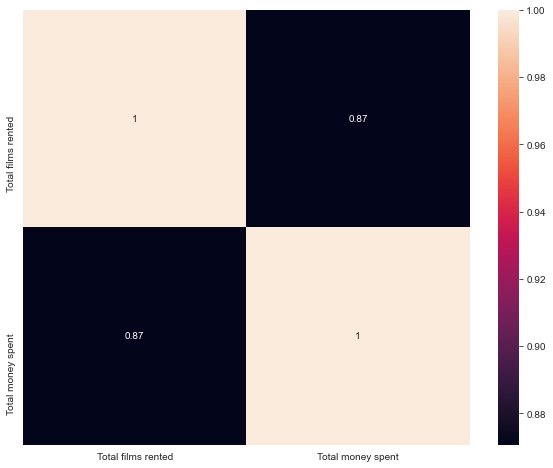

In [79]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

#### Distributions of numerical columns

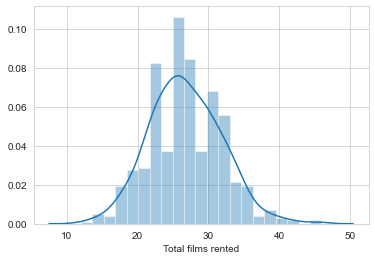

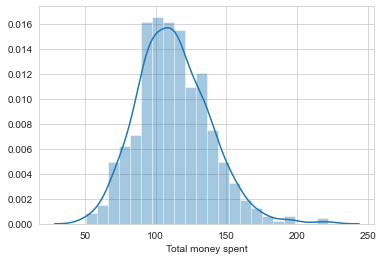

In [80]:
sns.distplot(data['Total films rented'])
plt.show()

sns.distplot(data['Total money spent'])
plt.show()

#### Transforming numerical columns with different transformers

In [103]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

X = data.select_dtypes(include = np.number)

X1 = X.copy()
X2 = X.copy()

In [105]:
data.head()

,Customer ID,City,Most rented category,Total films rented,Total money spent,Rented May,Rented June
0,599,Tieli,Sci-Fi,19,83.81,N,N
1,598,Lausanne,Drama,22,83.78,N,N
2,597,Sullana,Foreign,25,99.75,Y,N
3,596,Patras,Sports,28,96.72,Y,N
4,595,Jinzhou,Documentary,30,117.70,Y,Y


##### Normalizing

In [85]:
transformer = Normalizer().fit(X1)
x_normalized = transformer.transform(X1)
x_normalized = pd.DataFrame(x_normalized)

##### Standarizing

In [107]:
transformer = StandardScaler().fit(X2)
x_standarized = transformer.transform(X2)
x_standarized = pd.DataFrame(x_standarized)

# MODEL

#### Model 1: Independent variables standarized

In [114]:
y = data['Rented June']
X = np.concatenate((x_standarized, categorical), axis=1)

In [115]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [116]:
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(X_train, y_train)

C:\Users\yelam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [117]:
from sklearn.metrics import accuracy_score

predictions = classification.predict(X_test)

The accuracy of the model on test set is: 0.98 
[[233   0]
 [  5   2]]


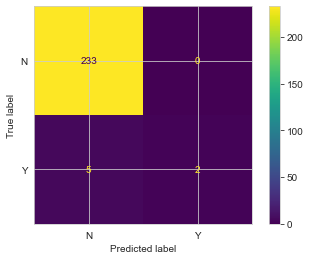

The Kappa of your model is: 0.44


In [118]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
plot_confusion_matrix(classification, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))